<a href="https://colab.research.google.com/github/Kinds-of-Intelligence-CFI/comparative-object-permanence/blob/measurement-layout/analysis/measurement-layouts/object_permanence_measurement_layout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative Object Permanence Measurement Layouts

Authors: K. Voudouris, J. Burden, J. Hernández-Orallo

## INIT

In [8]:
!pip install pymc
!pip install numpy
!pip install arviz
!pip install erroranalysis

In [9]:
import pymc as pm
import numpy as np
import arviz as az
import random as rm
from scipy import stats
import pandas as pd
import erroranalysis as ea
import matplotlib.pyplot as plt
import gc
from google.colab import files
import math
import seaborn as sns
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.2


## Load Data

In [11]:
agents_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/comparative-object-permanence/measurement-layout/analysis/measurement-layouts/results_final_clean_agents_wide.csv?token=GHSAT0AAAAAACEGARGQRLKWL6RP2TGQ42HOZG5K4AQ'
agent_data = pd.read_csv(agents_url)

children_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/comparative-object-permanence/measurement-layout/analysis/measurement-layouts/results_final_clean_children_wide.csv?token=GHSAT0AAAAAACEGARGR5QNXOXDPERRVL5VIZG5K4LA'
children_data = pd.read_csv(children_url)


## Define the Measurement Layout

In [18]:
## Helper functions

def logistic(x):
  return 1 / (1 + np.exp(-x))

def visualAcuityLOMargin(ability, goalSmallness): # must return a value between -inf and inf  (more precisely between -maxVisualAcuityAbility and maxVisualAcuityAbility)
  return ability - goalSmallness   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def SimplePrMargin(ability, binaryFeature): # must return a value between 0 and 1
  return 1-((1-ability)*binaryFeature)  # If binaryFeature is 0 then the margin represents p(success)=1. If binaryFeature = 1 then p(success)=ability

def flatNavMargin(ability, distanceToGoal, numTurns): # must return a value between -inf and inf  (more precisely between -maxSpatialAbility and maxSpatialAbility)
  return ability - (distanceToGoal * numTurns)   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def objPermanenceLOMargin(ability, allocentricocclusion, distanceToGoal, numPositions, maxPermAbility): #,  visualAcuityP): # must return a value between -inf and inf (more precisely between -maxPermAbility and maxPermAbility)
  OPPerformance = ability  - distanceToGoal * numPositions
  return maxPermAbility-((maxPermAbility-OPPerformance)*allocentricocclusion)


In [25]:
def SetupModel(taskResultsAll, uniformAbilitySlack, agent_type, agent_name = None):
  """
  taskResults is the conjunction of the metadata with the successes of the agents on that set of tests.
  """


  if agent_type == "agent":
    taskResults = taskResultsAll.dropna(subset = [agent_name])
    results = taskResults[agent_name]
  elif agent_type == "child":
    taskResults = taskResultsAll.dropna(subset = ['success'])
    results = taskResults['success']
  else:
    print("Agent not recognised. Quitting.")
    return

  abilityMin = {} #Initialize ability Min and max dataframes for plotting ranges
  abilityMax = {}

  #Decide "maximum capabilities" based on the hardest values in the dataset
  maxDistance = max(taskResults["cityBlockDistanceToGoal"])
  maxTurns = max(taskResults["minNumTurnsRequired"])
  maxChoices = max(taskResults["numChoices"])
  maxGoalSize = max(taskResults["mainGoalSize"])
  maxPermAbility = maxDistance * maxChoices * uniformAbilitySlack
  maxMemoryAbility = maxDistance * uniformAbilitySlack
  m = pm.Model()
  with m:

    objPermAbility = pm.Uniform("objPermAbility", 0, maxPermAbility)  # [0,maxPermAbility] This is the same as above, but we have the ability in the right magnitude
    abilityMin["objPermAbility"] = 0
    abilityMax["objPermAbility"] = maxPermAbility

    #memoryAbility = pm.Uniform("memoryAbility", 0, maxMemoryAbility)  # [0,maxMemoryAbility] This is the same as above, but we have the ability in the right magnitude
    #abilityMin["memoryAbility"] = 0
    #abilityMax["memoryAbility"] = maxMemoryAbility

    #Visual acuity
    maxVisualAcuityAbility = maxGoalSize* uniformAbilitySlack
    visualAcuityAbility = pm.Uniform("visualAcuityAbility", 0, maxVisualAcuityAbility)
    abilityMin["visualAcuityAbility"] = 0
    abilityMax["visualAcuityAbility"] = maxVisualAcuityAbility

    # Flat Navigation Ability
    flatNavAbility = pm.Uniform("flatNavAbility", 0, maxDistance*maxTurns)      # how much navigation is involved, i.e, how far away and how circuitous is the path to the goal?
    abilityMin["flatNavAbility"] =0
    abilityMax["flatNavAbility"] = maxDistance*maxTurns

    # Lava Ability
    lavaAbility = pm.Beta("lavaAbility", 1,1)                        # [0,1] Specific ability with lava
    abilityMin["lavaAbility"] = 0
    abilityMax["lavaAbility"] = 1

    # Ramp Ability
    rampAbility = pm.Beta("rampAbility",1,1)                          # [0,1] Specific ability with ramps
    abilityMin["rampAbility"] = 0
    abilityMax["rampAbility"] = 1

    # Goal Right Ability
    rightAbility = pm.Beta("rightAbility", 1, 1)
    abilityMin["rightAbility"] = 0
    abilityMax["rightAbility"] = 1

    # Goal Left Ability
    leftAbility = pm.Beta("leftAbility", 1, 1)
    abilityMin["leftAbility"] = 0
    abilityMax["leftAbility"] = 1

    # Goal Ahead Ability
    aheadAbility = pm.Beta("aheadAbility", 1, 1)
    abilityMin["aheadAbility"] = 0
    abilityMax["aheadAbility"] = 1



    ## Environment variables as Deterministic (about the instance)

    lavaPresence = pm.MutableData("lavaPresence", taskResults["lavaPresence"].values)
    rampPresence = pm.MutableData("rampPresence", taskResults["taskCriticalRampPresence"].values)
    lightsOutPresence = pm.MutableData("lightsOutPresence", taskResults["lightsOutPresence"].values)
    numGoals = pm.MutableData("numberOfGoals", taskResults["numGoalsAll"].values)
    numChoices = pm.MutableData("numChoices", taskResults["numChoices"].values)
    goalSize = pm.MutableData("goalSize",taskResults["mainGoalSize"].values)
    goalDist = pm.MutableData("goalDistance", taskResults["cityBlockDistanceToGoal"])
    numTurns = pm.MutableData("minTurnsToGoal", taskResults["minNumTurnsRequired"])
    goalRight = pm.MutableData("goalRight", taskResults["goalRightRelToStart"])
    goalAhead = pm.MutableData("goalAhead", taskResults["goalCentreRelToStart"])
    goalLeft = pm.MutableData("goalLeft", taskResults["goalLeftRelToStart"])
    opTest = pm.MutableData("allocentricOPTest", taskResults["goalBecomesAllocentricallyOccluded"])

    ## Margins

    goalSmallness = maxGoalSize - goalSize
    visualAcuityP = pm.Deterministic("visualAcuityP", logistic(visualAcuityLOMargin(visualAcuityAbility, goalSmallness)))

    rightP = pm.Deterministic("rightPerformance", SimplePrMargin(rightAbility, goalRight))
    aheadP = pm.Deterministic("aheadPerformance", SimplePrMargin(aheadAbility, goalAhead))
    leftP = pm.Deterministic("leftPerformance", SimplePrMargin(leftAbility, goalLeft))

    flatNavP = pm.Deterministic("flatNavP", logistic(flatNavMargin(flatNavAbility, goalDist, numTurns)))

    lavaP = pm.Deterministic("lavaP", SimplePrMargin(lavaAbility, lavaPresence))

    rampP = pm.Deterministic("rampP", SimplePrMargin(rampAbility, rampPresence))

    navP = pm.Deterministic("navP", (flatNavP * lavaP * rampP * rightP * aheadP * leftP)) #, visualAcuityP))

    OPLOM = objPermanenceLOMargin(objPermAbility, opTest, goalDist, numChoices, maxPermAbility)

    objPermP = pm.Deterministic("objPermP", logistic(OPLOM))

    taskPerformance = pm.Bernoulli("taskPerformance", (objPermP * navP * visualAcuityP), observed=results)

  pm.model_graph.model_to_graphviz(m)

  return m

In [14]:
agent_data.columns

Index(['Suite', 'SubSuite', 'Paradigm', 'Task', 'Instance', 'ColorVariant',
       'OccluderVariant', 'lavaPresence', 'taskCriticalRampPresence',
       'greenGoalPresence', 'yellowGoalPresence',
       'stationaryGreenGoalPresence', 'stationaryYellowGoalPresence',
       'movingGreenGoalPresence', 'movingYellowGoalPresence', 'numGreenGoals',
       'numYellowGoals', 'numGoalsAll', 'mainGoalSize', 'multipleGoalSameSize',
       'frozenAgentPresence', 'frozenAgentDelayLength', 'lightsOutPresence',
       'lightsOutAlternatingPresence', 'lightsOutPeriod',
       'goalBecomesAllocentricallyOccluded', 'opaqueWallNotPlatformPresence',
       'transparentWallPresence', 'bluePlatformPresence', 'decoyPresence',
       'decoySize', 'numDecoys', 'goalLeftRelToStart', 'goalCentreRelToStart',
       'goalRightRelToStart', 'forcedChoice', 'opaqueWallRedValue',
       'opaqueWallGreenValue', 'opaqueWallBlueValue',
       'opaqueWallColourRandomisationPresence', 'cityBlockDistanceToGoal',
       'min

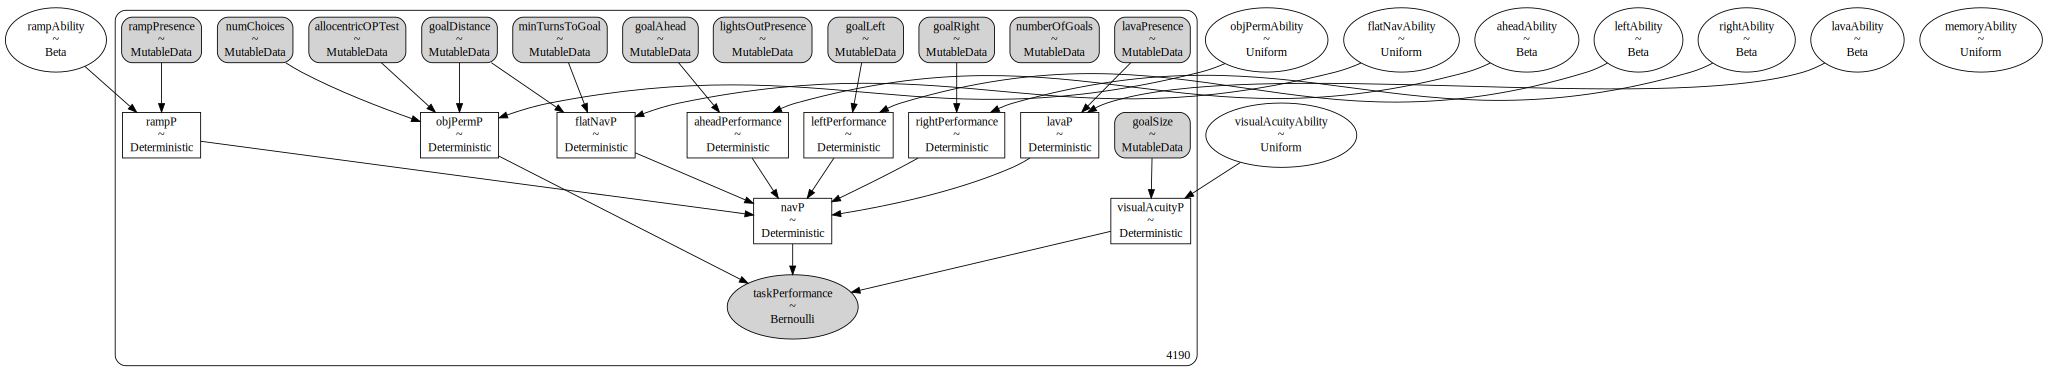

In [26]:
from IPython.display import Image
import graphviz

m = SetupModel(agent_data, uniformAbilitySlack=1.2, agent_type='agent', agent_name="Random_Walker_Rayleigh_Flight_Norm_Saccade_mu_15_sig_5_Uniform_Angles_1_to_60_3761")
gv = pm.model_graph.model_to_graphviz(m)
gv.format="png"
gv.render
#gv.render(directory='viz')
#Image("viz/Digraph.gv.png")
gv

In [27]:
with m:
    agentData = pm.sample(1000, target_accept=0.95) #Might need more samples to converge

In [32]:
agentData

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [28]:
def analyzeAgentResults(agentName, agentData, abilitiesToShow, displayFigs=False):

  abilityMeans = [] # empty list to add in ability means to
  abilitySDs = []
  for a in abilitiesToShow: #iterate through each ability, add posterior mean to dataframe, and plot posterior

    posteriorMean = float(np.mean(agentData['posterior'][a])) # calculate posterior mean
    posteriorSD = float(np.std(agentData['posterior'][a])) #calculate posterior sd
    abilityMeans.append(posteriorMean)
    abilitySDs.append(posteriorSD)

  return abilityMeans, abilitySDs

In [33]:
abilitiesToShow = ["objPermAbility", "flatNavAbility", "visualAcuityAbility","lavaAbility", "rampAbility", "leftAbility", "aheadAbility", "rightAbility"]
agentName = "Random_Walker_Rayleigh_Flight_Norm_Saccade_mu_15_sig_5_Uniform_Angles_1_to_60_3761"

abilitiesIncludingSuccess = abilitiesToShow + [agentName]



mu, sd  = analyzeAgentResults(agentName, agentData, abilitiesToShow)

In [34]:
mu

[340.8426133653524,
 875.9991163540453,
 4.3767386326235025,
 0.20655166016187781,
 0.4207313134538833,
 0.16433381465353963,
 0.5214836187928086,
 0.1851586489271949]

In [35]:
sd

[23.661788412642622,
 345.88237432642256,
 0.5016209298595776,
 0.03561079888145596,
 0.05389078842029677,
 0.031097149289639928,
 0.07051123950056529,
 0.03273981067461078]